## Imports

In [ ]:
import math
import os
import random

import git
import imageio
import magnum as mn
import numpy as np
from PIL import Image
import os

import cv2

%matplotlib inline
from matplotlib import pyplot as plt

# function to display the topdown map
from PIL import Image

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
print(f"data_path = {data_path}")
# @markdown Optionally configure the save path for video output:
output_directory = os.path.join(
    dir_path, "examples/tutorials/nav_output/"
)  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)
if not os.path.exists(output_path):
    os.mkdir(output_path)

from scripts_utils import *

import quaternion

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
from PIL import Image
from scipy.spatial import KDTree

import os

os.makedirs("data/topdown_maps", exist_ok=True)
os.makedirs("data/panoramas", exist_ok=True)
csv_file_path = os.path.join("data", "csv", "panorama_metadata.csv")


/home/jack/miniconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


data_path = /home/jack/Desktop/habitat-sim/data


## Settings

In [2]:
show_video = True
do_make_video = True
display = True

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

meters_per_pixel = 0.01

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [3]:
import os

def update_string_with_glb_file(data_folder, str_value):
    file_paths = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.glb'):
                # Extract the file name without extension
                glb_file_name = os.path.splitext(file)[0]
                
                # Replace the string value with the .glb file name
                str_value = glb_file_name
                
                # Full path of the .glb file
                glb_file_path = os.path.join(root, file)
                
                file_paths.append(glb_file_path)
                
                # If you need to save this update somewhere, you can add your saving logic here
                
    return file_paths

# Example usage
data_folder = data_path + '/scene_datasets/hm3d-val-habitat-v0.2/' # Root data folder containing subfolders with .glb files
initial_str_value = "initial_value"

# Update the string value with the .glb file name
updated_str_value = update_string_with_glb_file(data_folder, initial_str_value)

print(f"Updated string value: {updated_str_value}")

Updated string value: ['/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00828-X7gTkoDHViv/X7gTkoDHViv.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00833-dHwjuKfkRUR/dHwjuKfkRUR.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00813-svBbv1Pavdk/svBbv1Pavdk.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00831-yr17PDCnDDW/yr17PDCnDDW.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00863-b28CWbpQvor/b28CWbpQvor.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00824-Dd4bFSTQ8gi/Dd4bFSTQ8gi.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00862-LT9Jq6dN3Ea/LT9Jq6dN3Ea.basis.glb', '/home/jack/Desktop/habitat-sim/data/scene_datase

In [ ]:

# Function to get all navigable points (where the value is [128, 128, 128])
def get_navigable_points(img_array):
    """
    Get all navigable points (where the value is [128, 128, 128]) from the image array.

    Parameters:
    img_array (np.array): Image array representing the top-down map.

    Returns:
    np.array: Array of (x, y) coordinates of navigable points.
    """
    navigable_points = []
    for y in range(img_array.shape[0]):
        for x in range(img_array.shape[1]):
            if np.all(img_array[y, x] == [128, 128, 128]):
                navigable_points.append((x, y))
    return np.array(navigable_points)

# Function to sample points from the navigable points using K-means clustering
def sample_navigable_points(navigable_points, num_samples):
    """
    Sample points from the navigable points using K-means clustering.

    Parameters:
    navigable_points (np.array): Array of (x, y) coordinates of navigable points.
    num_samples (int): Number of points to sample.

    Returns:
    np.array: Array of (x, y) coordinates of sampled points.
    """
    kmeans = KMeans(n_clusters=num_samples)
    kmeans.fit(navigable_points)
    cluster_centers = kmeans.cluster_centers_

    # Snap cluster centers to the nearest navigable point
    tree = KDTree(navigable_points)
    _, indices = tree.query(cluster_centers)
    snapped_centers = navigable_points[indices]

    return snapped_centers


# Function to get 100 random navigable points
def random_navigable_points(navigable_points, num_samples=100):
    return np.array(random.sample(list(navigable_points), num_samples))
    

import numpy as np
from scipy.spatial import distance_matrix

def relative_neighborhood_graph(points):
    """
    Constructs a Relative Neighborhood Graph from a list of points.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.

    Returns:
    list of tuples: List of edges in the form of (point1, point2) where point1 and point2 are the coordinates of the points.
    """
    points = np.array(points)
    dist_matrix = distance_matrix(points, points)
    n = len(points)
    edges = []

    for i in range(n):
        for j in range(i + 1, n):
            edge_valid = True
            for k in range(n):
                if k != i and k != j:
                    if (dist_matrix[i][k] < dist_matrix[i][j] and dist_matrix[j][k] < dist_matrix[i][j]):
                        edge_valid = False
                        break
            if edge_valid:
                edges.append((tuple(points[i]), tuple(points[j])))
    
    return edges

def visualize_rng_on_image(points, edges, img):
    """
    Visualizes the Relative Neighborhood Graph on top of a topdown map image.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.
    edges (list of tuples): List of edges in the form of (point1, point2).
    image_path (str): Path to the image file representing the topdown map.
    """
    # transform the image to numpy array
    img = np.array(img)
    print(img.shape)
    # Load the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img, origin='upper')
    
    # Plot the points and edges
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    
    for edge in edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=1)
    
    plt.title('Relative Neighborhood Graph on Topdown Map')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True)
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from PIL import Image
from scipy.sparse.csgraph import connected_components
from scipy.spatial import KDTree

def edge_crosses_border(p1, p2, img_array):
    """
    Check if the edge between points p1 and p2 crosses a border in the image.
    
    Parameters:
    p1, p2 (tuple): Points representing the edge.
    img_array (np.array): Image array representing the topdown map.
    
    Returns:
    bool: True if the edge crosses a border, False otherwise.
    """
    x1, y1 = p1
    x2, y2 = p2
    x_values = np.linspace(x1, x2, 1000, dtype=int)
    y_values = np.linspace(y1, y2, 1000, dtype=int)
    
    for x, y in zip(x_values, y_values):
        if np.all(img_array[y, x] == [255, 255, 255]):
            return True
    return False

def remove_edges_crossing_borders(points, edges, img_array):
    """
    Remove edges that cross borders in the image.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.
    edges (list of tuples): List of edges in the form of (point1, point2).
    img_array (np.array): Image array representing the topdown map.
    
    Returns:
    list of tuples: List of edges after removing those crossing borders.
    """
    new_edges = []
    removed_edges = []
    for edge in edges:
        p1, p2 = edge
        if not edge_crosses_border(p1, p2, img_array):
            new_edges.append(edge)
        else:
            removed_edges.append(edge)
    return new_edges, removed_edges


def visualize_rng_on_image(points, edges, removed_edges, img):
    """
    Visualizes the Relative Neighborhood Graph on top of a topdown map image.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing points on the topdown map.
    edges (list of tuples): List of edges in the form of (point1, point2).
    image_path (str): Path to the image file representing the topdown map.
    """
    # transform the image to numpy array
    img = np.array(img)
    print(img.shape)
    # Load the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img, origin='upper')
    
    # Plot the points and edges
    points = np.array(points)
    plt.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    
    for edge in edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=1)
    
    for edge in removed_edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=1, linestyle='dashed')
    
    plt.title('Relative Neighborhood Graph on Topdown Map')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True)
    plt.show()




PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[17:58:43:303085]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[17:58:43:303234]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00828-X7gTkoDHViv/X7gTkoDHViv.basis.scndoes not exist.  Aborting load.
[17:58:43:303249]:[Warning]:[Scene] SemanticScene.cpp(121)

agent_state: position [1. 1. 0.] rotation quaternion(1, 0, 0, 0)
sensor_spec:  {'__noise_model_kwargs': {}}
Renderer: Quadro P1000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 555.42.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-imag

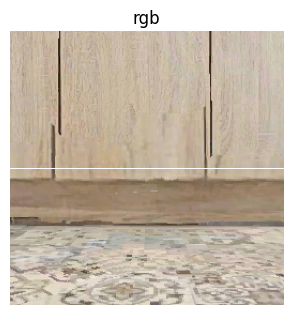


Display topdown map with agent:


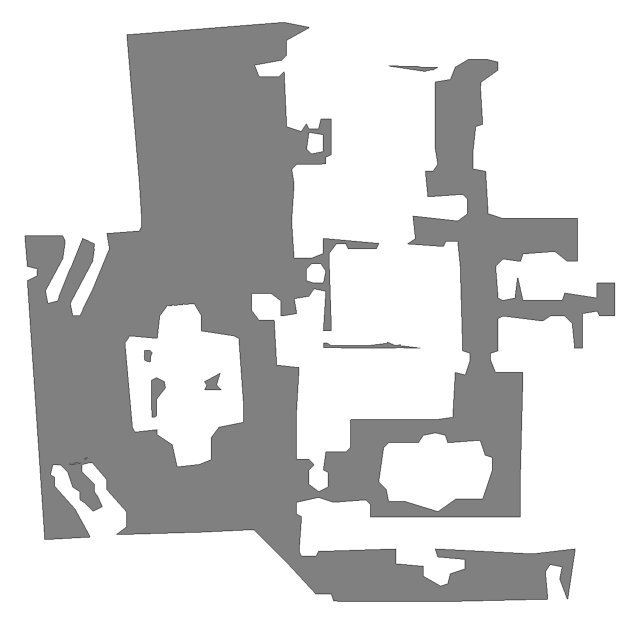

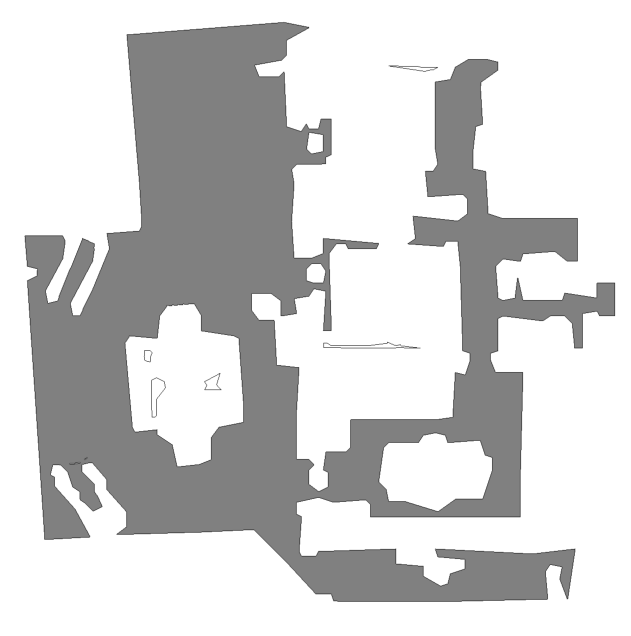

Number of samples: 111
Number of sampled points: 111


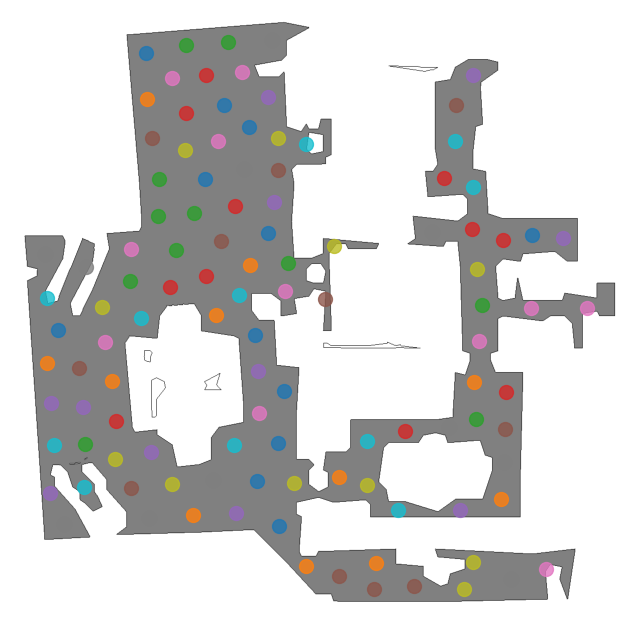

Are all points navigable? True


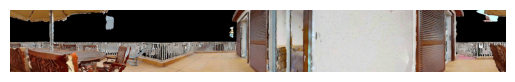

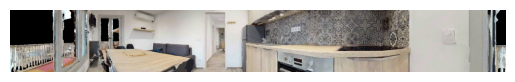

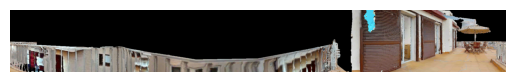

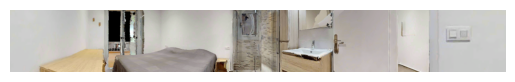

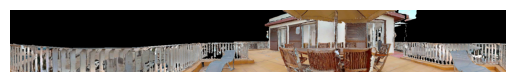

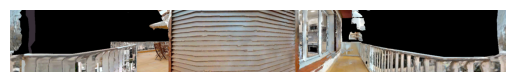

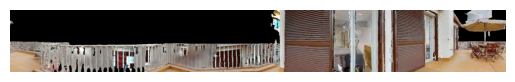

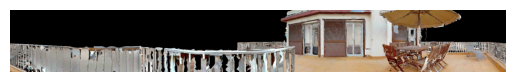

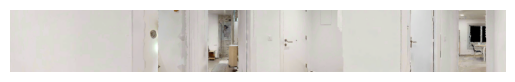

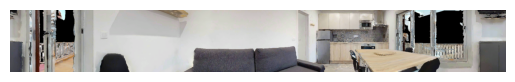

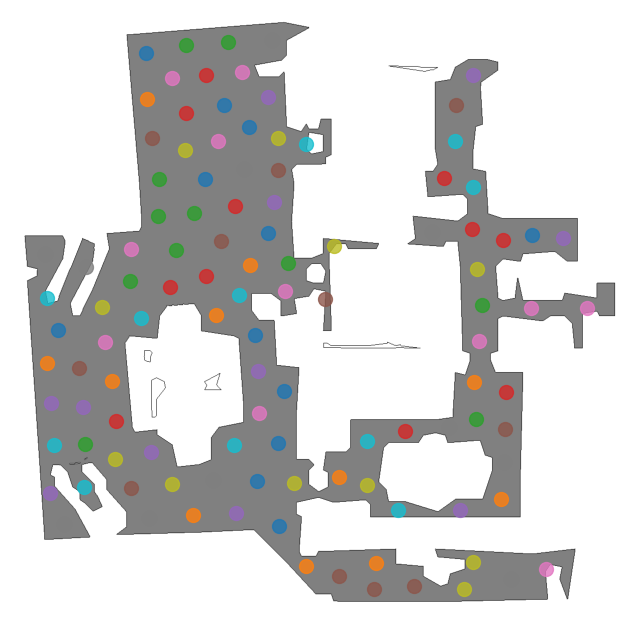

Saved 111 panoramas for environment 0 in data/panoramas/env_0
agent_state: position [1. 1. 0.] rotation quaternion(1, 0, 0, 0)
sensor_spec:  {'__noise_model_kwargs': {}}
Renderer: Quadro P1000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 555.42.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-co

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[17:59:12:197428]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[17:59:12:197635]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00833-dHwjuKfkRUR/dHwjuKfkRUR.basis.scndoes not exist.  Aborting load.
[17:59:12:197653]:[Warning]:[Scene] SemanticScene.cpp(121)

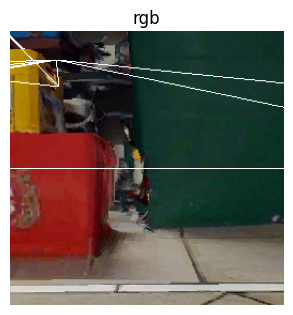


Display topdown map with agent:


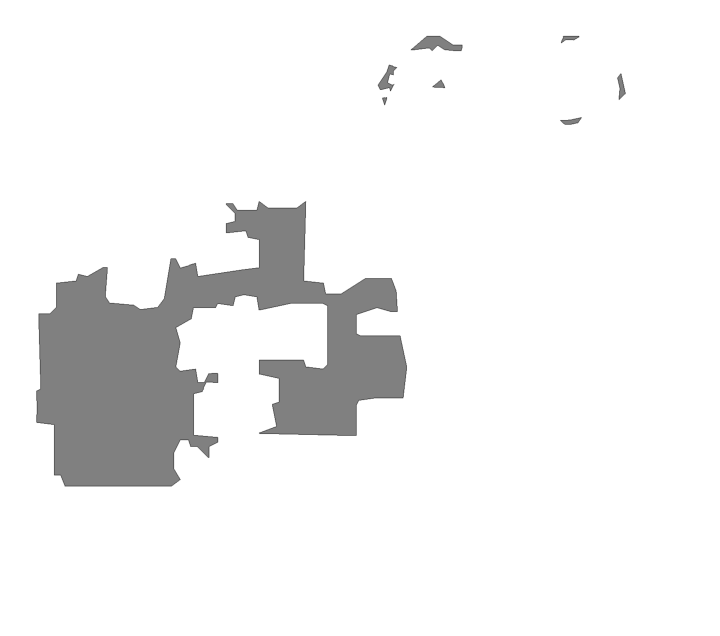

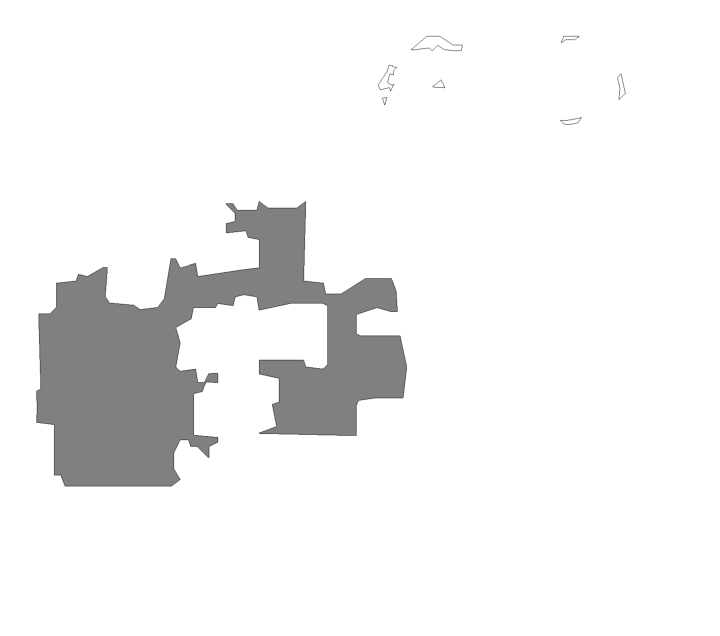

Number of samples: 49
Number of sampled points: 49


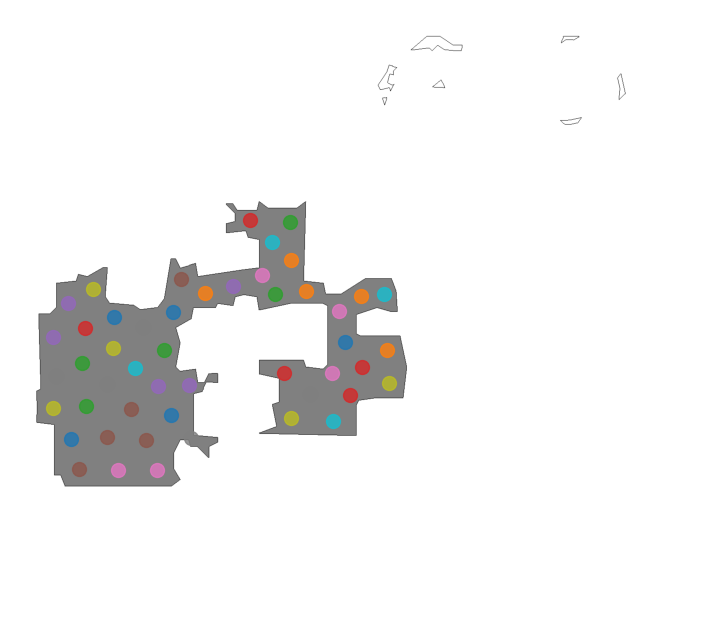

Are all points navigable? True


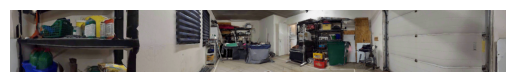

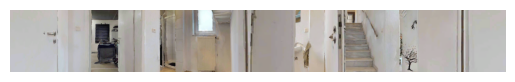

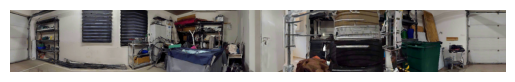

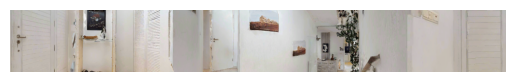

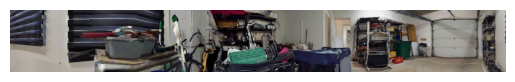

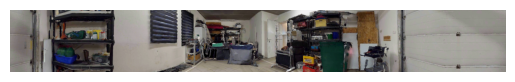

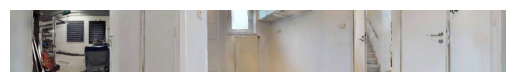

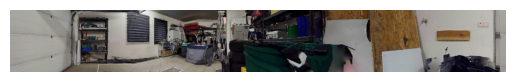

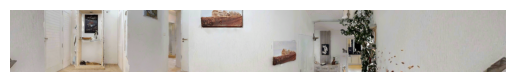

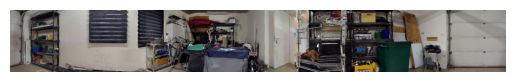

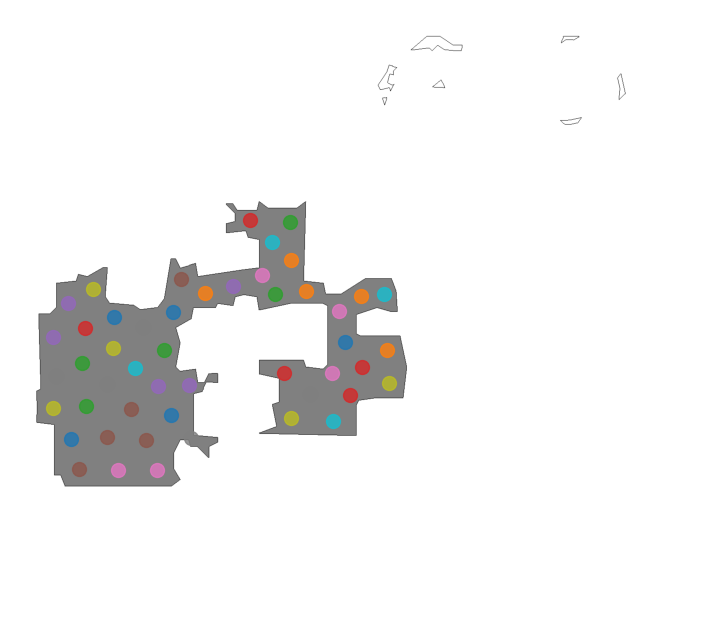

Saved 49 panoramas for environment 1 in data/panoramas/env_1
agent_state: position [1. 1. 0.] rotation quaternion(1, 0, 0, 0)
sensor_spec:  {'__noise_model_kwargs': {}}
Successfully snapped point to: [0.         0.07754743 0.        ]
Agent state: AgentState(position=array([0.        , 0.07754743, 0.        ], dtype=float32), rotation=quaternion(0.7109135389328, -0, -0.703279376029968, -0), sensor_states={'color_sensor': SixDOFPose(position=array([0.        , 0.07754743, 0.        ], dtype=float32), rotation=quaternion(0.7109135389328, 0, -0.703279376029968, 0))})
 position = [0.         0.07754743 0.        ]
 rotation = quaternion(0.7109135389328, -0, -0.703279376029968, -0)
 orientation (about Y) = 1.56
Renderer: Quadro P1000/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 555.42.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[17:59:40:989940]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[17:59:40:990080]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: File/home/jack/Desktop/habitat-sim/data/scene_datasets/hm3d-val-habitat-v0.2/00813-svBbv1Pavdk/svBbv1Pavdk.basis.scndoes not exist.  Aborting load.
[17:59:40:990096]:[Warning]:[Scene] SemanticScene.cpp(121)

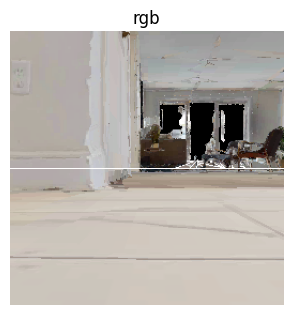


Display topdown map with agent:


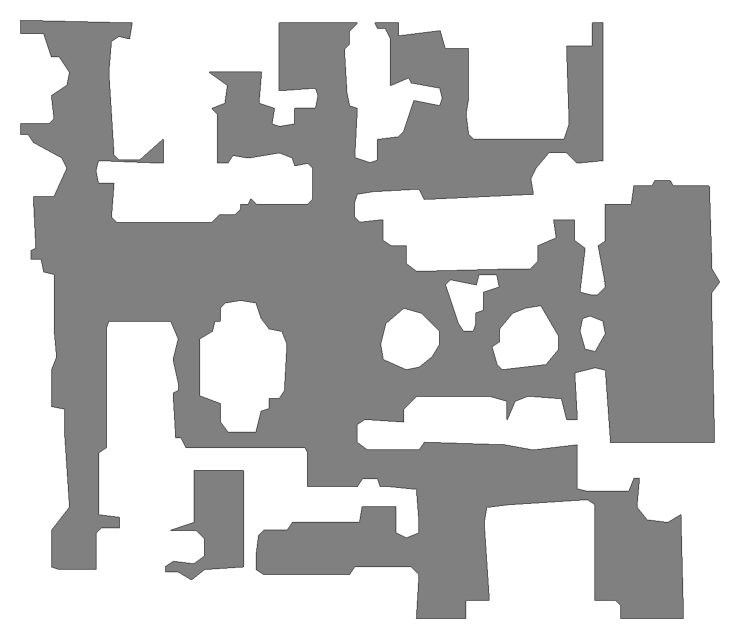

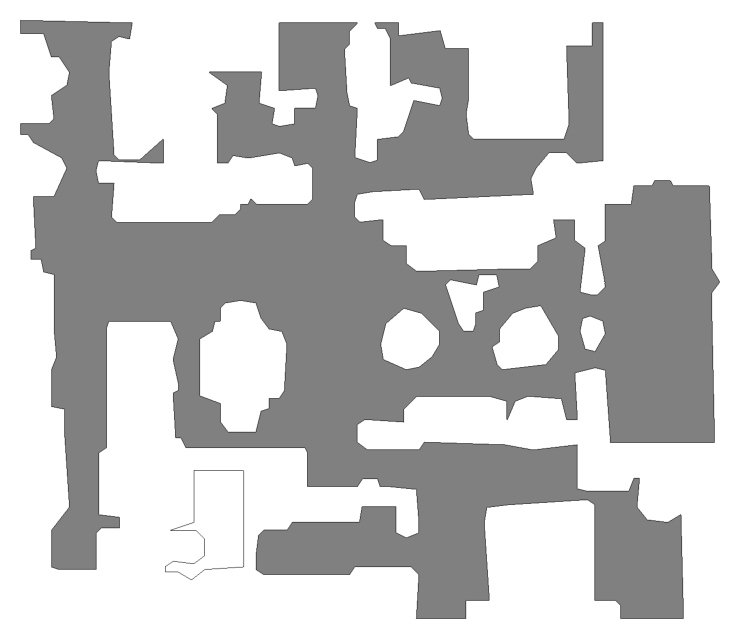

KeyboardInterrupt: 

In [ ]:
# This is the scene we are going to load.
# we support a variety of mesh formats, such as .glb, .gltf, .obj, .ply
# test_scene = os.path.join(
#     data_path, "scene_datasets/hm3d-minival-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb"
# )
for env_idx in range(len(updated_str_value)):
    panoramas = []
    test_scene = updated_str_value[env_idx]
    rgb_sensor = True

    sim_settings = {
        "scene": test_scene,  # Scene path
        "default_agent": 0,  # Index of the default agent
        "sensor_height": 0.0, #1.5,  # Height of sensors in meters, relative to the agent
        "agent_height": 1.0,  # Height of the agent in meters
        "agent_radius": 0.1,  # Radius of the agent in meters
        "width": 256,  # Spatial resolution of the observations
        "height": 256, 
        "sensor_hfov": 45,  # Horizontal field of view of the sensors
        "color_sensor": rgb_sensor,  # RGB sensor
        "seed": 1,  # used in the random navigation
        "enable_physics": True,  # kinematics only
    }

    cfg = make_cfg(sim_settings)
    # Needed to handle out of order cell run in Jupyter
    try:  # Got to make initialization idiot proof
        sim.close()
    except NameError:
        pass
    sim = habitat_sim.Simulator(cfg)

    # initialize an agent
    agent = sim.initialize_agent(sim_settings["default_agent"])

    # Set agent state
    agent_state = habitat_sim.AgentState()
    agent_state.position = np.array([1, 1, 0.0])  # in world space
    agent.set_state(agent_state)

    # Get agent state
    agent_state = agent.get_state()
    print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

    sensor_spec = sim._sensors.get("color_sensor")
    print("sensor_spec: ", sensor_spec._spec.__dict__)

    ## Recompute NavMesh:

    # Take a moment to edit some parameters and visualize the resulting NavMesh. Consider agent_radius and agent_height as the most impactful starting point. Note that large variations from the defaults for these parameters (e.g. in the case of very small agents) may be better supported by additional changes to cell_size and cell_height.
    navmesh_settings = habitat_sim.NavMeshSettings()

    # Choose Habitat-sim defaults (e.g. for point-nav tasks), or custom settings.
    use_custom_settings = True  # @param {type:"boolean"}
    sim.navmesh_visualization = True  # @param {type:"boolean"}
    navmesh_settings.set_defaults()
    if use_custom_settings:
        #@markdown Configure the following NavMeshSettings for customized NavMesh recomputation.
        #@markdown **Voxelization parameters**:
        navmesh_settings.cell_size = 0.05 #default = 0.05
        navmesh_settings.cell_height = 0.2 #default = 0.2

        #@markdown **Agent parameters**:
        navmesh_settings.agent_height = sim_settings["agent_height"] #default = 1.5
        navmesh_settings.agent_radius = sim_settings["agent_radius"] #default = 0.1
        navmesh_settings.agent_max_climb = 0.2 #default = 0.2
        navmesh_settings.agent_max_slope = 45 # default = 45.0
        
        # @markdown **Navigable area filtering options**:
        navmesh_settings.filter_low_hanging_obstacles = True  # default = True
        navmesh_settings.filter_ledge_spans = True # default = True
        navmesh_settings.filter_walkable_low_height_spans = True  # default = True

        #@markdown **Detail mesh generation parameters**:
        #@markdown For more details on the effects
        navmesh_settings.region_min_size = 20 #default = 20
        navmesh_settings.region_merge_size = 20 #default = 20
        navmesh_settings.edge_max_len = 12.0 #default = 12.0
        navmesh_settings.edge_max_error = 1.3 #default = 1.3
        navmesh_settings.verts_per_poly = 6.0 #default = 6.0
        navmesh_settings.detail_sample_dist = 6.0 #default = 6.0
        navmesh_settings.detail_sample_max_error = 1.0 # default = 1.0

        # @markdown **Include STATIC Objects**:
        # @markdown Optionally include all instanced RigidObjects with STATIC MotionType as NavMesh constraints.
        navmesh_settings.include_static_objects = True  # @param {type:"boolean"}
        # default = False

    navmesh_success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)

    if not navmesh_success:
        print("Failed to build the navmesh! Try different parameters?")
    else:
        # @markdown **Agent parameters**:
        agent_state = sim.agents[0].get_state()
        set_random_valid_state = False  
        seed = 5  
        sim.seed(seed)
        orientation = 0
        if set_random_valid_state:
            agent_state.position = sim.pathfinder.get_random_navigable_point()
            orientation = random.random() * math.pi * 2.0
        # Optionally configure the agent state (overrides random state):
        set_agent_state = True  # @param {type:"boolean"}
        try_to_make_valid = True  # @param {type:"boolean"}
        if set_agent_state:
            pos_x = 0  # @param {type:"number"}
            pos_y = 0  # @param {type:"number"}
            pos_z = 0.0  # @param {type:"number"}
            # Y axis rotation (radians):
            orientation = 1.56  # @param {type:"number"}
            agent_state.position = np.array([pos_x, pos_y, pos_z])
            if try_to_make_valid:
                snapped_point = np.array(sim.pathfinder.snap_point(agent_state.position))
                if not np.isnan(np.sum(snapped_point)):
                    print("Successfully snapped point to: " + str(snapped_point))
                    agent_state.position = snapped_point
        if set_agent_state or set_random_valid_state:
            agent_state.rotation = utils.quat_from_magnum(
                mn.Quaternion.rotation(-mn.Rad(orientation), mn.Vector3(0, 1.0, 0))
            )
            sim.agents[0].set_state(agent_state)

        agent_state = sim.agents[0].get_state()
        print("Agent state: " + str(agent_state))
        print(" position = " + str(agent_state.position))
        print(" rotation = " + str(agent_state.rotation))
        print(" orientation (about Y) = " + str(orientation))

        observations = sim.get_sensor_observations()
        rgb = observations["color_sensor"]

        if display:
            display_sample(rgb)
            # **Map parameters**:
            agent_pos = agent_state.position
            # topdown map at agent position
            top_down_map = maps.get_topdown_map(
                sim.pathfinder, height=agent_pos[1], meters_per_pixel=meters_per_pixel
            )
            recolor_map = np.array(
                [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
            )
            top_down_map = recolor_map[top_down_map]
            grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
            # convert world agent position to maps module grid point
            agent_grid_pos = maps.to_grid(
                agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder
            )
            agent_forward = utils.quat_to_magnum(
                sim.agents[0].get_state().rotation
            ).transform_vector(mn.Vector3(0, 0, -1.0))
            agent_orientation = math.atan2(agent_forward[0], agent_forward[2])
            # draw the agent and trajectory on the map
            # maps.draw_agent(
            #     top_down_map, agent_grid_pos, agent_orientation, agent_radius_px=4
            # )
            print("\nDisplay topdown map with agent:")
            display_map(top_down_map)

        sim.reset()

        from scipy.ndimage import label, find_objects

        # Convert to binary map where 1 is navigable and 0 is not
        binary_map = (top_down_map == 128).astype(np.uint8)

        # Label connected components
        labeled_map, num_features = label(binary_map)

        # Find the largest connected component
        sizes = np.bincount(labeled_map.ravel())
        sizes[0] = 0  # Background size to 0
        largest_component_label = sizes.argmax()
        size_of_env = max(sizes)

        # Create a mask for the largest component
        largest_component_mask = (labeled_map == largest_component_label)

        # Create the final navigation map, keeping the borders as they are
        final_navigation_map = np.where(largest_component_mask, 128, 255)

        # Ensure the borders of the largest component are kept as they are in the original map
        final_navigation_map[top_down_map == 0] = 0

        # Display the final navigation map
        display_map(final_navigation_map)

        top_down_map = (final_navigation_map).astype(np.uint8)

        # Example usage
        # Get navigable points
        navigable_points = get_navigable_points(top_down_map)

        # Number of points to sample (adjust this ratio as needed)
        num_samples = int(0.0002 * len(navigable_points))
        # if size_of_env< 500000 and size_of_env > 300000:
        #     num_samples = int(np.round(num_samples*1.5))
        # elif size_of_env > 500000:
        #     num_samples = int(np.round(num_samples*2))

        print(f"Number of samples: {num_samples}")

        # Sample navigable points
        points = sample_navigable_points(navigable_points, num_samples)

        print(f"Number of sampled points: {len(points)}")

        # Display the map with sampled points
        display_map(top_down_map, key_points=points)

        # check if all the points are navigable
        cond = True
        for point in points:
            if not np.all(top_down_map[point[1], point[0]] == [128, 128, 128]):
                cond = False
                break
        print(f"Are all points navigable? {cond}")

        sim.navmesh_visualization = False

        if not sim.pathfinder.is_loaded:
            print("Pathfinder not initialized, aborting.")
        else:
            seed = 4  # Seed for random processes
            sim.pathfinder.seed(seed)

            scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb

            display_path_agent_renders = True
            if display_path_agent_renders:
                agent_state = habitat_sim.AgentState()
                vis_frames = []  # List to store rendered frames

                # Process each point
                for ix, point in enumerate(points):
                    point_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
                    point_3d = mn.Vector3(point_3d)
                    agent_state.position = point_3d  # Set the agent's position

                    # Compute initial north-facing orientation
                    target_orientation_matrix = mn.Matrix4.look_at(
                        point_3d, point_3d + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
                    )
                    initial_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())

                    for rotation in [0, 45, 90, 135, 180, 225,  270, 315]:
                    # for rotation in [0, 90, 180, 270]:
                        rad = degrees_to_magnum_rad(rotation)  # Convert degrees to radians
                        rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))  # Rotate around the upward y-axis
                        total_orientation_q = rotation_q * initial_orientation_q  # Apply the rotation

                        # Convert the total orientation from Magnum to quaternion library format
                        q = total_orientation_q
                        agent_state.rotation = utils.quat_from_magnum(total_orientation_q)  # Set the agent's orientation

                        agent.set_state(agent_state)  # Apply state to the agent

                        # Capture sensor observations
                        observations = sim.get_sensor_observations()
                        rgb = observations["color_sensor"]

                        # # crop the image for narrower (45 degrees) field of view instead of 90 degrees
                        # height, width, _ = rgb.shape

                        # # Calculate new width to simulate 45-degree FOV
                        # new_width = width // 2

                        # # Calculate left, right coordinates to keep the center of the image
                        # left = (width - new_width) // 2
                        # right = left + new_width 
                        # rgb = rgb[:, left:right, :]

                        vis_frames.append(rgb)

        # split the frames such that each part has 8 images
        split_frames = [vis_frames[i:i + 8] for i in range(0, len(vis_frames), 8)]

        # flip the order of the images in each part
        split_frames = [frames[::-1] for frames in split_frames]

        # stitch the images in each part
        panoramas = [stitch_images(frames) for frames in split_frames]

    for i in range(min(len(panoramas), 10)):
        plt.imshow(panoramas[i])
        plt.axis("off")
        plt.show()


    display_map(top_down_map, key_points=points)

    # # Ensure output directories exist
    # os.makedirs("data/topdown_maps", exist_ok=True)
    # os.makedirs("data/panoramas", exist_ok=True)

   
    # env_topdown_path = os.path.join("data", "topdown_maps", f"env_{env_idx}.png")
    # Image.fromarray(top_down_map).save(env_topdown_path)  # No color processing

    # # ---- Save Panoramas ----
    # pano_folder = os.path.join("data", "panoramas", f"env_{env_idx}")
    # os.makedirs(pano_folder, exist_ok=True)

    # for pano_idx, pano_img in enumerate(panoramas):
    #     pano_path = os.path.join(pano_folder, f"pano_{pano_idx}.png")
    #     Image.fromarray(pano_img).save(pano_path)  # No channel swapping










In [ ]:
# This is the scene we are going to load.
# we support a variety of mesh formats, such as .glb, .gltf, .obj, .ply
# test_scene = os.path.join(
#     data_path, "scene_datasets/hm3d-minival-habitat-v0.2/00804-BHXhpBwSMLh/BHXhpBwSMLh.basis.glb"
# )
for env_idx in range(len(updated_str_value)):
    panoramas = []
    test_scene = updated_str_value[env_idx]
    rgb_sensor = True

    sim_settings = {
        "scene": test_scene,  # Scene path
        "default_agent": 0,  # Index of the default agent
        "sensor_height": 0.0, #1.5,  # Height of sensors in meters, relative to the agent
        "agent_height": 1.0,  # Height of the agent in meters
        "agent_radius": 0.1,  # Radius of the agent in meters
        "width": 256,  # Spatial resolution of the observations
        "height": 256, 
        "sensor_hfov": 45,  # Horizontal field of view of the sensors
        "color_sensor": rgb_sensor,  # RGB sensor
        "seed": 1,  # used in the random navigation
        "enable_physics": True,  # kinematics only
    }

    cfg = make_cfg(sim_settings)
    # Needed to handle out of order cell run in Jupyter
    try:  # Got to make initialization idiot proof
        sim.close()
    except NameError:
        pass
    sim = habitat_sim.Simulator(cfg)

    # initialize an agent
    agent = sim.initialize_agent(sim_settings["default_agent"])

    # Set agent state
    agent_state = habitat_sim.AgentState()
    agent_state.position = np.array([1, 1, 0.0])  # in world space
    agent.set_state(agent_state)

    # Get agent state
    agent_state = agent.get_state()
    print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

    sensor_spec = sim._sensors.get("color_sensor")
    print("sensor_spec: ", sensor_spec._spec.__dict__)

    ## Recompute NavMesh:

    # Take a moment to edit some parameters and visualize the resulting NavMesh. Consider agent_radius and agent_height as the most impactful starting point. Note that large variations from the defaults for these parameters (e.g. in the case of very small agents) may be better supported by additional changes to cell_size and cell_height.
    navmesh_settings = habitat_sim.NavMeshSettings()

    # Choose Habitat-sim defaults (e.g. for point-nav tasks), or custom settings.
    use_custom_settings = True  # @param {type:"boolean"}
    sim.navmesh_visualization = True  # @param {type:"boolean"}
    navmesh_settings.set_defaults()
    if use_custom_settings:
        #@markdown Configure the following NavMeshSettings for customized NavMesh recomputation.
        #@markdown **Voxelization parameters**:
        navmesh_settings.cell_size = 0.05 #default = 0.05
        navmesh_settings.cell_height = 0.2 #default = 0.2

        #@markdown **Agent parameters**:
        navmesh_settings.agent_height = sim_settings["agent_height"] #default = 1.5
        navmesh_settings.agent_radius = sim_settings["agent_radius"] #default = 0.1
        navmesh_settings.agent_max_climb = 0.2 #default = 0.2
        navmesh_settings.agent_max_slope = 45 # default = 45.0
        
        # @markdown **Navigable area filtering options**:
        navmesh_settings.filter_low_hanging_obstacles = True  # default = True
        navmesh_settings.filter_ledge_spans = True # default = True
        navmesh_settings.filter_walkable_low_height_spans = True  # default = True

        #@markdown **Detail mesh generation parameters**:
        #@markdown For more details on the effects
        navmesh_settings.region_min_size = 20 #default = 20
        navmesh_settings.region_merge_size = 20 #default = 20
        navmesh_settings.edge_max_len = 12.0 #default = 12.0
        navmesh_settings.edge_max_error = 1.3 #default = 1.3
        navmesh_settings.verts_per_poly = 6.0 #default = 6.0
        navmesh_settings.detail_sample_dist = 6.0 #default = 6.0
        navmesh_settings.detail_sample_max_error = 1.0 # default = 1.0

        # @markdown **Include STATIC Objects**:
        # @markdown Optionally include all instanced RigidObjects with STATIC MotionType as NavMesh constraints.
        navmesh_settings.include_static_objects = True  # @param {type:"boolean"}
        # default = False

    navmesh_success = sim.recompute_navmesh(sim.pathfinder, navmesh_settings)

    if not navmesh_success:
        print("Failed to build the navmesh! Try different parameters?")
    else:
        # @markdown **Agent parameters**:
        agent_state = sim.agents[0].get_state()
        set_random_valid_state = False  
        seed = 5  
        sim.seed(seed)
        orientation = 0
        if set_random_valid_state:
            agent_state.position = sim.pathfinder.get_random_navigable_point()
            orientation = random.random() * math.pi * 2.0
        # Optionally configure the agent state (overrides random state):
        set_agent_state = True  # @param {type:"boolean"}
        try_to_make_valid = True  # @param {type:"boolean"}
        if set_agent_state:
            pos_x = 0  # @param {type:"number"}
            pos_y = 0  # @param {type:"number"}
            pos_z = 0.0  # @param {type:"number"}
            # Y axis rotation (radians):
            orientation = 1.56  # @param {type:"number"}
            agent_state.position = np.array([pos_x, pos_y, pos_z])
            if try_to_make_valid:
                snapped_point = np.array(sim.pathfinder.snap_point(agent_state.position))
                if not np.isnan(np.sum(snapped_point)):
                    print("Successfully snapped point to: " + str(snapped_point))
                    agent_state.position = snapped_point
        if set_agent_state or set_random_valid_state:
            agent_state.rotation = utils.quat_from_magnum(
                mn.Quaternion.rotation(-mn.Rad(orientation), mn.Vector3(0, 1.0, 0))
            )
            sim.agents[0].set_state(agent_state)

        agent_state = sim.agents[0].get_state()
        print("Agent state: " + str(agent_state))
        print(" position = " + str(agent_state.position))
        print(" rotation = " + str(agent_state.rotation))
        print(" orientation (about Y) = " + str(orientation))

        observations = sim.get_sensor_observations()
        rgb = observations["color_sensor"]

        if display:
            display_sample(rgb)
            # **Map parameters**:
            agent_pos = agent_state.position
            # topdown map at agent position
            top_down_map = maps.get_topdown_map(
                sim.pathfinder, height=agent_pos[1], meters_per_pixel=meters_per_pixel
            )
            recolor_map = np.array(
                [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
            )
            top_down_map = recolor_map[top_down_map]
            grid_dimensions = (top_down_map.shape[0], top_down_map.shape[1])
            # convert world agent position to maps module grid point
            agent_grid_pos = maps.to_grid(
                agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder
            )
            agent_forward = utils.quat_to_magnum(
                sim.agents[0].get_state().rotation
            ).transform_vector(mn.Vector3(0, 0, -1.0))
            agent_orientation = math.atan2(agent_forward[0], agent_forward[2])
            # draw the agent and trajectory on the map
            # maps.draw_agent(
            #     top_down_map, agent_grid_pos, agent_orientation, agent_radius_px=4
            # )
            print("\nDisplay topdown map with agent:")
            display_map(top_down_map)

        sim.reset()

        from scipy.ndimage import label, find_objects

        # Convert to binary map where 1 is navigable and 0 is not
        binary_map = (top_down_map == 128).astype(np.uint8)

        # Label connected components
        labeled_map, num_features = label(binary_map)

        # Find the largest connected component
        sizes = np.bincount(labeled_map.ravel())
        sizes[0] = 0  # Background size to 0
        largest_component_label = sizes.argmax()
        size_of_env = max(sizes)

        # Create a mask for the largest component
        largest_component_mask = (labeled_map == largest_component_label)

        # Create the final navigation map, keeping the borders as they are
        final_navigation_map = np.where(largest_component_mask, 128, 255)

        # Ensure the borders of the largest component are kept as they are in the original map
        final_navigation_map[top_down_map == 0] = 0

        # Display the final navigation map
        display_map(final_navigation_map)

        top_down_map = (final_navigation_map).astype(np.uint8)

        # Example usage
        # Get navigable points
        navigable_points = get_navigable_points(top_down_map)

        # Number of points to sample (adjust this ratio as needed)
        num_random_samples = int(0.0001 * len(navigable_points))
        random_points = random_navigable_point(navigable_points, num_samples)
        # if size_of_env< 500000 and size_of_env > 300000:
        #     num_samples = int(np.round(num_samples*1.5))
        # elif size_of_env > 500000:
        #     num_samples = int(np.round(num_samples*2))

        print(f"Number of samples: {num_samples}")

        # Sample navigable points

        print(f"Number of sampled points: {len(points)}")

        # Display the map with sampled points
        display_map(top_down_map, key_points=points)

        # check if all the points are navigable
        cond = True
        for point in points:
            if not np.all(top_down_map[point[1], point[0]] == [128, 128, 128]):
                cond = False
                break
        print(f"Are all points navigable? {cond}")

        sim.navmesh_visualization = False

        if not sim.pathfinder.is_loaded:
            print("Pathfinder not initialized, aborting.")
        else:
            seed = 4  # Seed for random processes
            sim.pathfinder.seed(seed)

            scene_bb = sim.get_active_scene_graph().get_root_node().cumulative_bb

            display_path_agent_renders = True
            if display_path_agent_renders:
                agent_state = habitat_sim.AgentState()
                vis_frames = []  # List to store rendered frames

                # Process each point
                for ix, point in enumerate(points):
                    point_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
                    point_3d = mn.Vector3(point_3d)
                    agent_state.position = point_3d  # Set the agent's position

                    # Compute initial north-facing orientation
                    target_orientation_matrix = mn.Matrix4.look_at(
                        point_3d, point_3d + mn.Vector3(0, 0, 1), mn.Vector3(0, 1, 0)
                    )
                    initial_orientation_q = mn.Quaternion.from_matrix(target_orientation_matrix.rotation())

                    for rotation in [0, 45, 90, 135, 180, 225,  270, 315]:
                    # for rotation in [0, 90, 180, 270]:
                        rad = degrees_to_magnum_rad(rotation)  # Convert degrees to radians
                        rotation_q = mn.Quaternion.rotation(rad, mn.Vector3(0, 1, 0))  # Rotate around the upward y-axis
                        total_orientation_q = rotation_q * initial_orientation_q  # Apply the rotation

                        # Convert the total orientation from Magnum to quaternion library format
                        q = total_orientation_q
                        agent_state.rotation = utils.quat_from_magnum(total_orientation_q)  # Set the agent's orientation

                        agent.set_state(agent_state)  # Apply state to the agent

                        # Capture sensor observations
                        observations = sim.get_sensor_observations()
                        rgb = observations["color_sensor"]

                        # # crop the image for narrower (45 degrees) field of view instead of 90 degrees
                        # height, width, _ = rgb.shape

                        # # Calculate new width to simulate 45-degree FOV
                        # new_width = width // 2

                        # # Calculate left, right coordinates to keep the center of the image
                        # left = (width - new_width) // 2
                        # right = left + new_width 
                        # rgb = rgb[:, left:right, :]

                        vis_frames.append(rgb)

        # split the frames such that each part has 8 images
        split_frames = [vis_frames[i:i + 8] for i in range(0, len(vis_frames), 8)]

        # flip the order of the images in each part
        split_frames = [frames[::-1] for frames in split_frames]

        # stitch the images in each part
        panoramas = [stitch_images(frames) for frames in split_frames]

    for i in range(min(len(panoramas), 10)):
        plt.imshow(panoramas[i])
        plt.axis("off")
        plt.show()


    display_map(top_down_map, key_points=points)

    # # Ensure output directories exist
    # os.makedirs("data/topdown_maps", exist_ok=True)
    # os.makedirs("data/panoramas", exist_ok=True)

   
    # env_topdown_path = os.path.join("data", "topdown_maps", f"env_{env_idx}.png")
    # Image.fromarray(top_down_map).save(env_topdown_path)  # No color processing

    # # ---- Save Panoramas ----
    # pano_folder = os.path.join("data", "panoramas", f"env_{env_idx}")
    # os.makedirs(pano_folder, exist_ok=True)

    # for pano_idx, pano_img in enumerate(panoramas):
    #     pano_path = os.path.join(pano_folder, f"pano_{pano_idx}.png")
    #     Image.fromarray(pano_img).save(pano_path)  # No channel swapping

    print(f"Saved {len(panoramas)} panoramas for environment {env_idx} in {pano_folder}")
    
    with open(csv_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        if os.stat(csv_file_path).st_size == 0:
            writer.writerow(["image_idx", "x", "y", "z"])  # Write header if file is empty

        for point_idx, (pano_img, point) in enumerate(zip(panoramas, points)):
            image_filename = f"{env_idx}_{point_idx}.png"
            image_path = os.path.join("data", "panoramas", image_filename)
            Image.fromarray(pano_img).save(image_path)  # Save image
            
            point_3d = convert_topdown_to_3d(sim.pathfinder, [point], meters_per_pixel, sim_settings["agent_height"])[0]
            writer.writerow([image_filename, point_3d[0], point_3d[1], point_3d[2]])

        print(f"Saved panoramas and updated metadata CSV at {csv_file_path}")






